# Tutorial: MRI Parallel Imaging Reconstruction from raw k-space data

# Notebook uses code from the following demos :
https://github.com/facebookresearch/fastMRI/blob/main/fastMRI_tutorial.ipynb 
https://github.com/mrirecon/bart-workshop/blob/master/ismrm2016/pics-brain/demo.ipynb
https://github.com/mrirecon/bart-workshop/blob/master/mri_together_2023/bart_mritogether_2023.ipynb
https://github.com/mrirecon/bart-webinars/blob/master/webinar4/demo/demo.ipynb

This notebook demonstrates how to use BART for parallel MRI reconstruction. 

To run locally, we'll need:

1. a `bart` installation (v0.7.00 or later) 

2. a `python3` programming environment

3. to expose our `python3` instance to `bart`'s python bindings in `/path/to/bart/python`. 

We can check our environment by importing the necessary libraries:

In [41]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import os
import nibabel as nib

from scipy.signal import convolve2d
import torch

In [42]:
import fastmri
from fastmri.data import transforms as T

In [43]:
import cfl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import os
import bart

In [44]:
from skimage.metrics import structural_similarity as ssim

In [45]:
import time
from fastmri.data.subsample import *
from fastmri.data import transforms as T
import fastmri

In [46]:
from fastmri.data.subsample import EquispacedMaskFractionFunc

In [149]:
import sys
sys.path.append(os.getcwd())
import eval

# Helper methods

In [135]:
def disp(im, figsize=(10,10), title=''): # to avoid code repetition
    _, ax = plt.subplots(figsize=figsize)
    ax.imshow(abs(np.squeeze(im)), cmap='gray')
    ax.set_title(title)


In [136]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(50,50))
    
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [137]:
def crop_center(data):
    dim_size = data.shape[2]
    goal_size = data.shape[3]
    d = int((dim_size-goal_size)/2)
    center = int(dim_size/2)
    new_data = data[:,:,center-d:center+d,:]
    return new_data
    

In [138]:
def normalize_abs(not_norm):
    norm = np.squeeze(np.abs(not_norm))
    norm = (norm - norm.min()) / (norm.max() - norm.min())
    return norm
    

In [139]:
def recon_epics(kspace_in, calib,reg_type = 'wavelet'):


    ksp_masked_b1 = kspace_in[None]
    ksp_masked_b = ksp_masked_b1.transpose(0,2,3,1)
    
    smap = bart.bart(1, 'ecalib -m 1 -S', ksp_masked_b)
    

    #im_rss = bart.bart(1, 'rss {}'.format(num[0]), im_coil)
    if(reg_type == 'wavelet'): #l1-wavelet
        lam = 0.01
        num = !bart bitmask 1 2
        im_out = bart.bart(1, 'pics -R W:{}:0:{} -S -s {}'.format(num[0], lam, 1), ksp_masked_b, smap)
    elif(reg_type == 'l2'): # l2-norm in image domain
        lam = 0.01
        im_out = bart.bart(1, 'pics -R Q:{} -S -s {}'.format(lam), ksp_masked_b, smap, 1)
    elif(reg_type == 'l1'): # l1-norm in image domain
        lam = 0.01
        im_out = bart.bart(1, 'pics -R I:{} -S -s {}'.format(lam), ksp_masked_b, smap, 1)
    elif(reg_type == 'total_var'): # l2-norm in image domain
        lam = 0.01
        im_out = bart.bart(1, 'pics -R t:{}:0:{} -S -s {}'.format(num[0], lam), ksp_masked_b, smap,1)
    else:
        im_out = bart.bart(1, 'pics -S', ksp_masked_b, smap,1)

    return im_out


    

In [140]:
def recon_epics_vol(vol_kspace, calib=""):
    calib = ""
    print(vol_kspace.shape)
    out = torch.zeros((vol_kspace.shape[0],vol_kspace.shape[2],vol_kspace.shape[3]))
    print(out.shape)
    num_slices = vol_kspace.shape[0]

    for ss in range(num_slices):
        kspace_in = vol_kspace[ss]
        out[ss] =  torch.tensor(np.abs(recon_epics(kspace_in, calib)))
    return out

# Load data

In [141]:
fnames = [ 'file_brain_AXT2_210_6001747.h5']

In [142]:
data_folder = 'fastMRI_data/dataset5/brain'; # REPLACE WITH YOUR PATH
file_name = os.path.join(data_folder, fnames[0])

# Data structure

In [143]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT1', 'max': 0.0011712071065250477, 'norm': 0.1939936983717164, 'patient_id': '7bb001a4044720cb56b304c4147dada28e266a9e7c40aa28e3d8f0ad4b0db222'}


In [144]:
volume_kspace = hf['kspace'][()]
out = hf['reconstruction_rss'][()]

print('Kspace shape:',volume_kspace.shape)
print('reconstruction rss shape:',out.shape)

Kspace shape: (16, 16, 640, 320)
reconstruction rss shape: (16, 320, 320)


In [145]:
print("Num slices",volume_kspace.shape[0])
print("Num coils",volume_kspace.shape[1])

Num slices 16
Num coils 16


In [146]:
print("Use example slice 8 for visualization")
slice_kspace = volume_kspace[8] # Choosing the 8-th slice of this volume
out_rss = out[8]
print("Slice shape: ",slice_kspace.shape)


Use example slice 8 for visualization
Slice shape:  (16, 640, 320)


# Raw fully-sampled coil data

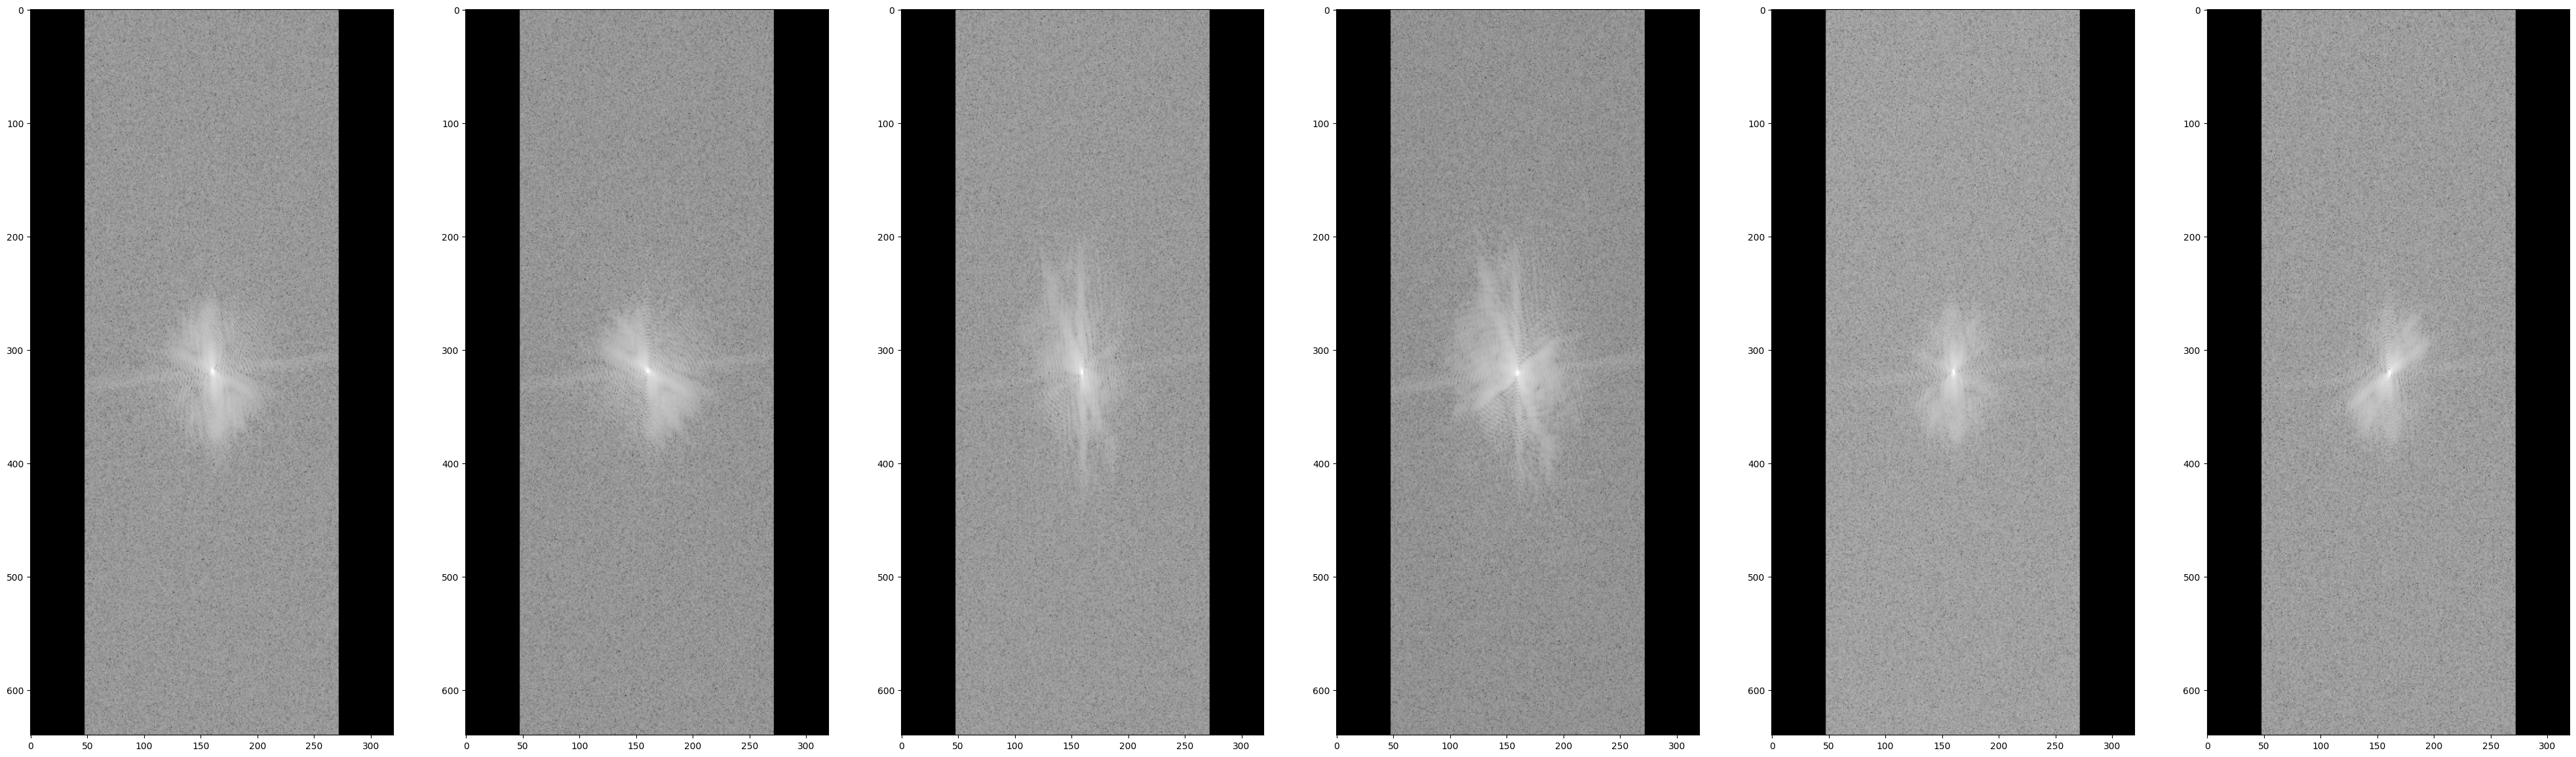

In [147]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 1, 2, 3,4,5], cmap='gray')  # This shows coils 0, 1, 2 and 3

In [148]:
#show_coils(np.log(np.abs(slice_kspace) + 1e-9),[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])  # This shows coils 0, 1, 2 and 3

In [61]:
slice_kspace2 = T.to_tensor(slice_kspace)            # Convert from numpy array to pytorch tensor, seperates real and imaginary in two dimensions 
slice_image = fastmri.ifft2c(slice_kspace2)          # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

# Individual coil data

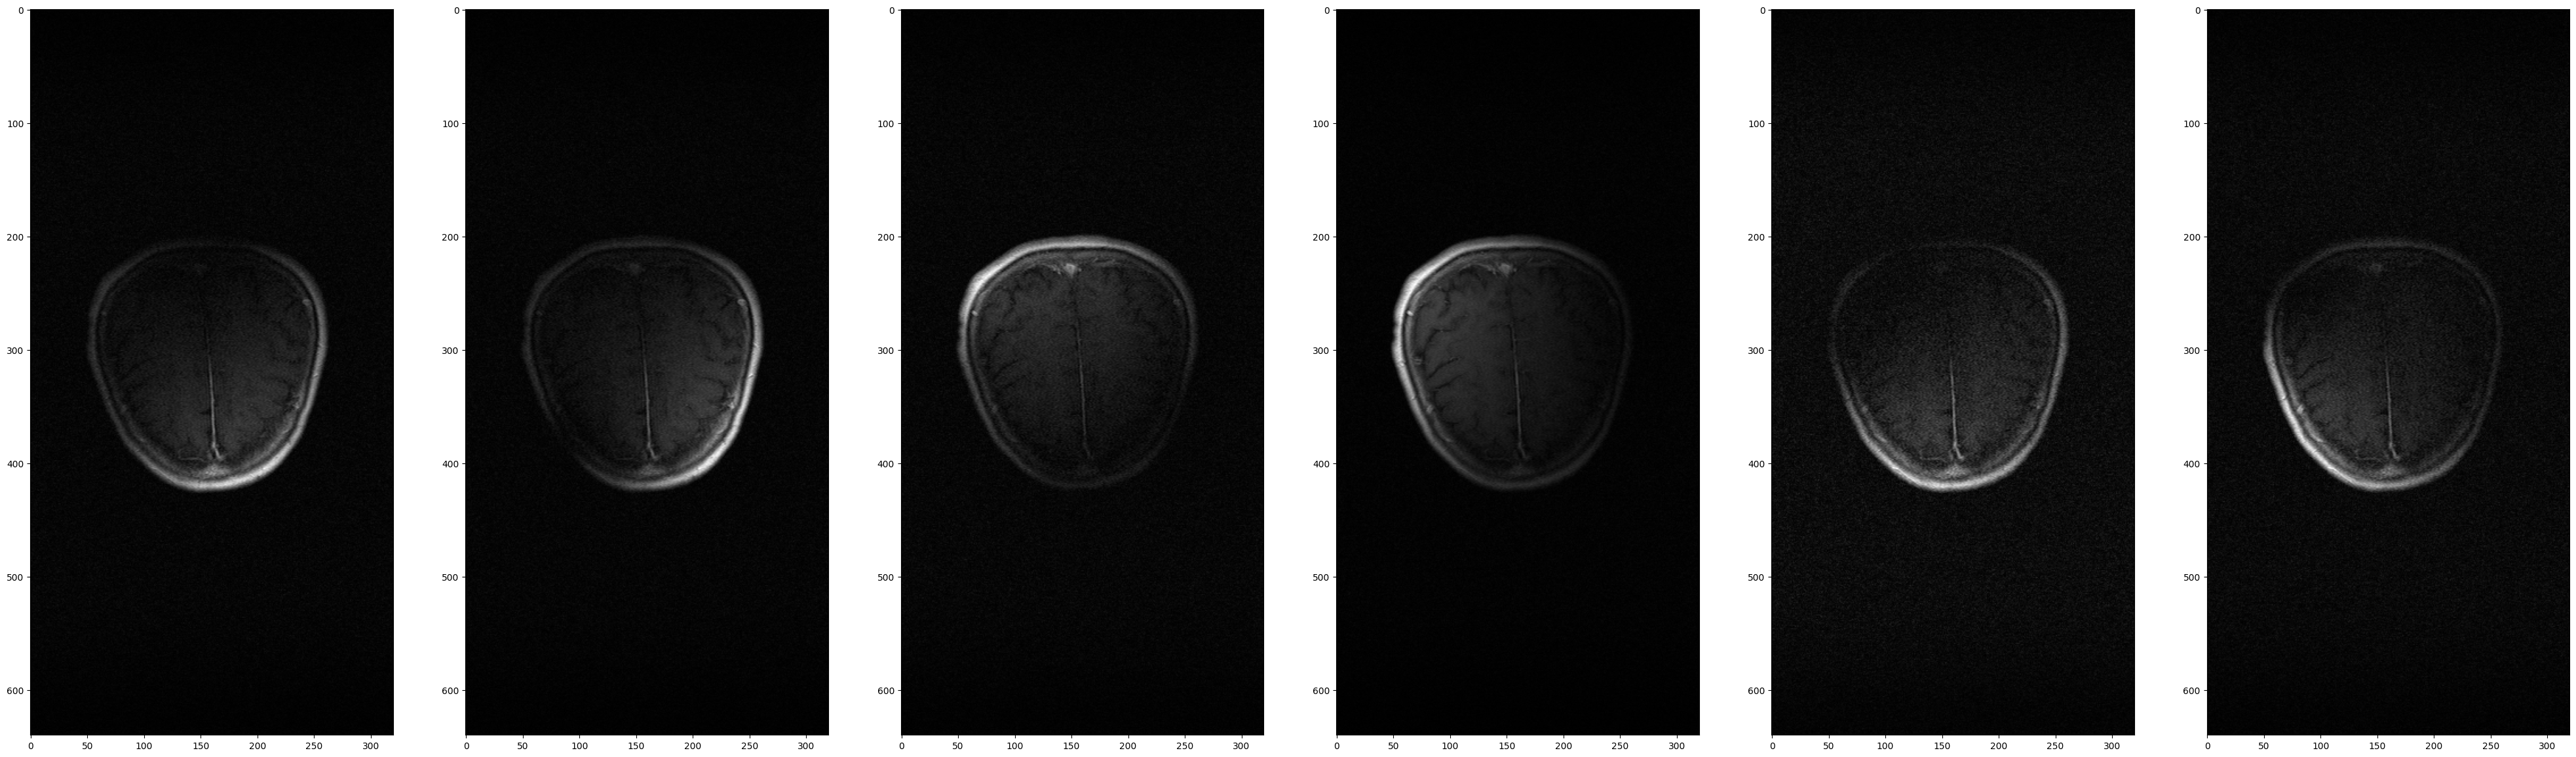

In [62]:
show_coils(slice_image_abs, [0, 1, 2, 3,4,5], cmap='gray')

# Format coil and image data

In [63]:
ksp_ful_nonoise_b = slice_kspace[None]
ksp_ful_nonoise_b = ksp_ful_nonoise_b.transpose(0,2,3,1)
ksp_ful_nonoise_b.shape

(1, 640, 320, 16)

In [64]:
im_coil_b = slice_image_abs[None]
im_coil_b = im_coil_b.numpy().transpose(0,2,3,1)
im_coil_b.shape

(1, 640, 320, 16)

# Sum of squares recon from images

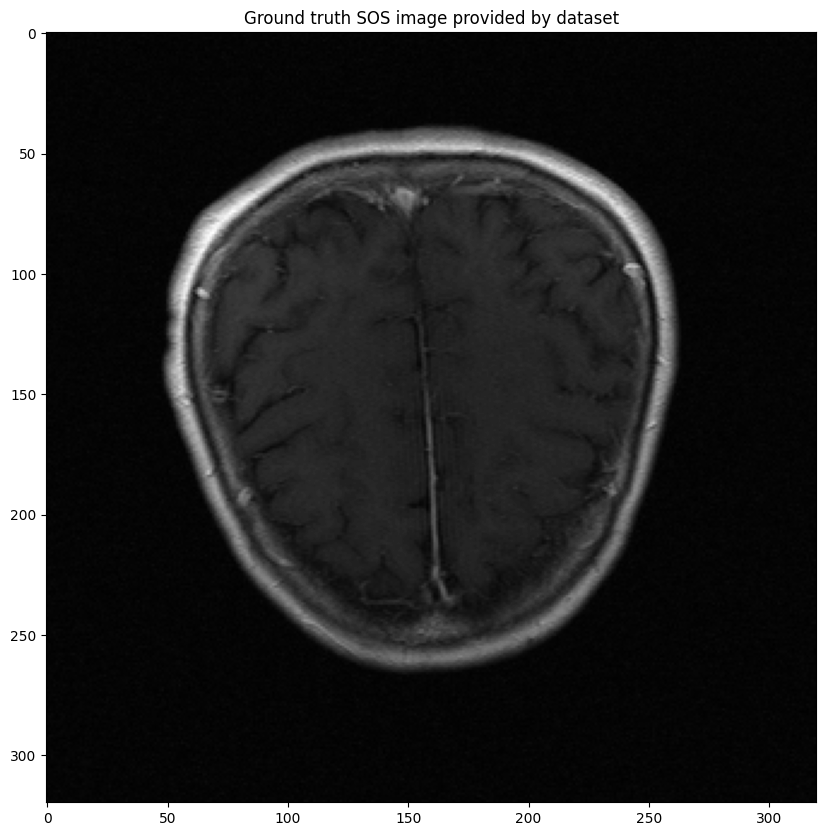

In [65]:
disp(out_rss, title='Ground truth SOS image provided by dataset')

# Artificially downsample k-space

In [66]:
from fastmri.data.subsample import EquispacedMaskFractionFunc
#mask_func = EquispacedMaskFractionFunc(center_fractions=[0.04], accelerations=[3])  # Create the mask function object

In [67]:
slice_kspace2 = T.to_tensor(slice_kspace)            # Convert from numpy array to pytorch tensor, seperates real and imaginary in two dimensions 
slice_image = fastmri.ifft2c(slice_kspace2)          # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
mask_func = EquispacedMaskFractionFunc(center_fractions=[0.04], accelerations=[3])  # Create the mask function object
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Text(0.5, 1.0, 'mask applied to k-space')

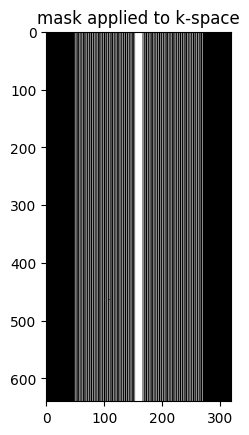

In [171]:
# Visualize mask
plt.imshow(np.abs(masked_kspace[0,:,:,0])>0, cmap='gray')
plt.title("mask applied to k-space")

# Result of doing reconstruction without filling in missing k-space

In [70]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

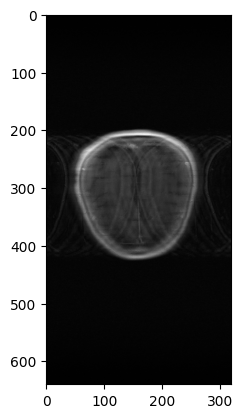

In [71]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

# Get sensitvity maps using ecalib (espirit method)

### look at way to call the method

In [72]:
!bart ecalib -h

Usage: ecalib [-t f] [-c f] [-k d:d:d] [-r d:d:d] [-m d] [-S] [-W] [-I] [-1] [-P] [-v f] [-a] [-d d] <kspace> <sensitivities> [<ev-maps>] 

Estimate coil sensitivities using ESPIRiT calibration.
Optionally outputs the eigenvalue maps.

-t threshold     This determined the size of the null-space.
-c crop_value    Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-k ksize         kernel size
-r cal_size      Limits the size of the calibration region.
-m maps          Number of maps to compute.
-S               create maps with smooth transitions (Soft-SENSE).
-W               soft-weighting of the singular vectors.
-I               intensity correction
-1               perform only first part of the calibration
-P               Do not rotate the phase with respect to the first principal component
-v variance      Variance of noise in data.
-a               Automatically pick thresholds.
-d level         Debug level
-h               help


In [73]:
!bart ecalib -h

Usage: ecalib [-t f] [-c f] [-k d:d:d] [-r d:d:d] [-m d] [-S] [-W] [-I] [-1] [-P] [-v f] [-a] [-d d] <kspace> <sensitivities> [<ev-maps>] 

Estimate coil sensitivities using ESPIRiT calibration.
Optionally outputs the eigenvalue maps.

-t threshold     This determined the size of the null-space.
-c crop_value    Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-k ksize         kernel size
-r cal_size      Limits the size of the calibration region.
-m maps          Number of maps to compute.
-S               create maps with smooth transitions (Soft-SENSE).
-W               soft-weighting of the singular vectors.
-I               intensity correction
-1               perform only first part of the calibration
-P               Do not rotate the phase with respect to the first principal component
-v variance      Variance of noise in data.
-a               Automatically pick thresholds.
-d level         Debug level
-h               help


### Format k-space to match bart specification

In [77]:
masked_kspace_numpy_2 = masked_kspace.numpy()
masked_kspace_numpy_1 = masked_kspace_numpy_2[:, :, :, 0] + 1j * masked_kspace_numpy_2[:, :, :, 1]

In [78]:
ksp_masked_b1 = masked_kspace_numpy_1[None]
ksp_masked_b = ksp_masked_b1.transpose(0,2,3,1)
ksp_masked_b.shape

(1, 640, 320, 16)

### Note hyper parameters change the masks produced, for example applying -S command changes the size of the mask

Calibration region...  (size: 1x24x12, pos: 0x308x154)
Energy: 0.480 0.322 0.126 0.037 0.020 0.008 0.004 0.002 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000
Build calibration matrix and SVD...
Eigen decomposition... (size: 576)
Using 26/576 kernels (4.51%, last SV: 0.033500).
Zeropad...
FFT (juggling)...
Calculate Gram matrix...
Resize...
Point-wise eigen-decomposition...
Crop maps... (c = 0.80)
Fix phase...
Done.


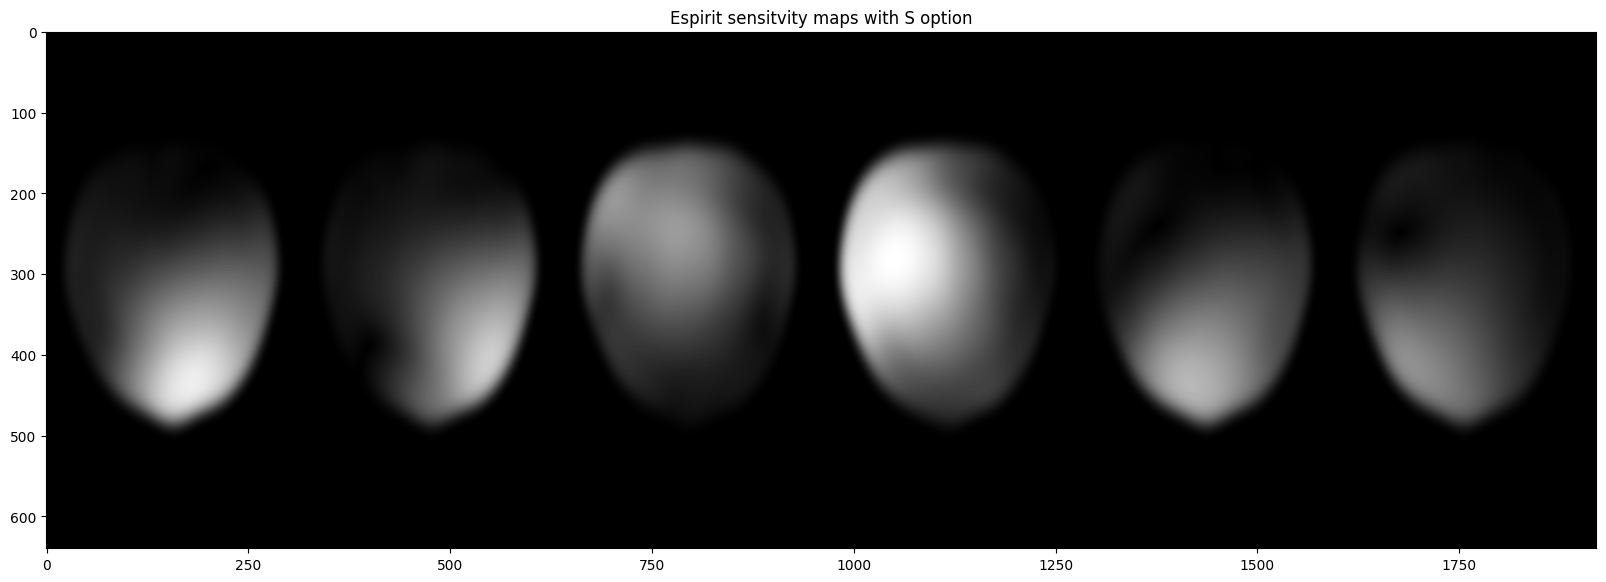

In [79]:
smap = bart.bart(1, 'ecalib -m 1 -S -d3', ksp_masked_b)
disp(np.concatenate([np.abs(smap[0,:,:,i]) for i in range(6)], 1), figsize=(20,8), title = "Espirit sensitvity maps with S option")

Calibration region...  (size: 1x24x12, pos: 0x308x154)
Energy: 0.480 0.322 0.126 0.037 0.020 0.008 0.004 0.002 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000
Build calibration matrix and SVD...
Eigen decomposition... (size: 576)
Using 26/576 kernels (4.51%, last SV: 0.033500).
Zeropad...
FFT (juggling)...
Calculate Gram matrix...
Resize...
Point-wise eigen-decomposition...
Crop maps... (c = 0.80)
Fix phase...
Done.


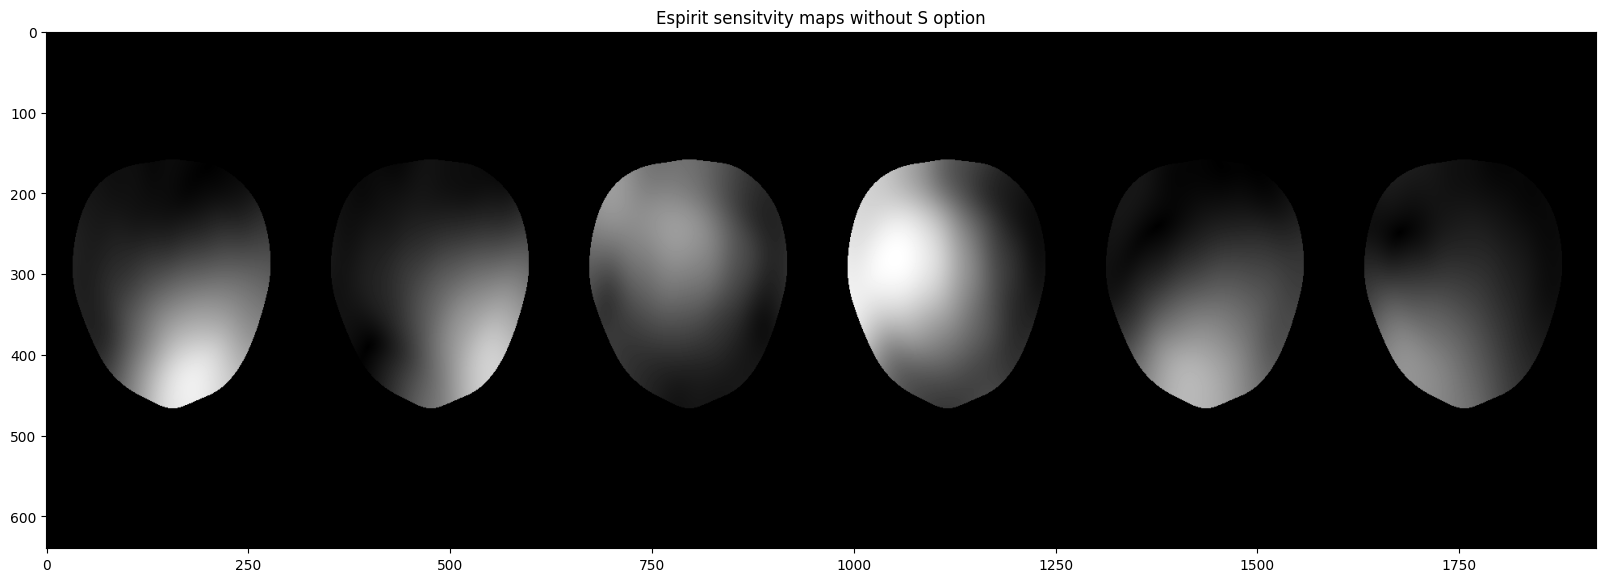

In [80]:
smap = bart.bart(1, 'ecalib -m 1 -d3', ksp_masked_b)
disp(np.concatenate([np.abs(smap[0,:,:,i]) for i in range(6)], 1), figsize=(20,8), title = "Espirit sensitvity maps without S option")

## Do reconstruction using PICS with the sensitvity maps calculated above

### Explore different types of regularization

In [85]:
!bart pics -Rh -h #Rh command is for regularization, add -d option for

Generalized regularization options (experimental)

-R <T>:A:B:C	<T> is regularization type (single letter),
		A is transform flags, B is joint threshold flags,
		and C is regularization value. Specify any number
		of regularization terms.

-R Q:C    	l2-norm in image domain
-R I:B:C  	l1-norm in image domain
-R W:A:B:C	l1-wavelet
-R N:A:B:C	Normalized Iterative Hard Thresholding (NIHT), image domain
		C is an integer percentage, i.e. from 0-100
-R H:A:B:C	NIHT, wavelet domain
-R F:A:B:C	l1-Fourier
-R T:A:B:C	total variation
-R T:7:0:.01	3D isotropic total variation with 0.01 regularization.
-R G:A:B:C	total generalized variation
-R C:A:B:C	infimal convolution TV
-R L:7:7:.02	Locally low rank with spatial decimation and 0.02 regularization.
-R M:7:7:.03	Multi-scale low rank with spatial decimation and 0.03 regularization.
-R TF:{graph_path}:lambda	TensorFlow loss


Size: 204800 Samples: 49280 Acc: 4.16
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 1.869448


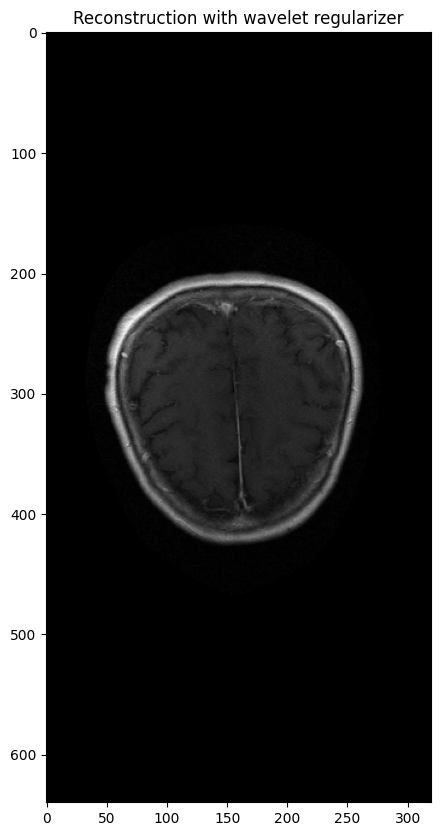

In [87]:
l1wav_reg = 0.01
num = !bart bitmask 1 2
#im_rss = bart.bart(1, 'rss {}'.format(num[0]), im_coil)

im_wav = bart.bart(1, 'pics -R W:{}:0:{} -S -s {}'.format(num[0], l1wav_reg, 1), ksp_masked_b, smap)
disp(im_wav, title="Reconstruction with wavelet regularizer")

Size: 204800 Samples: 49280 Acc: 4.16
Regularization terms: 0, Supporting variables: 0
conjugate gradients
Total Time: 1.671176


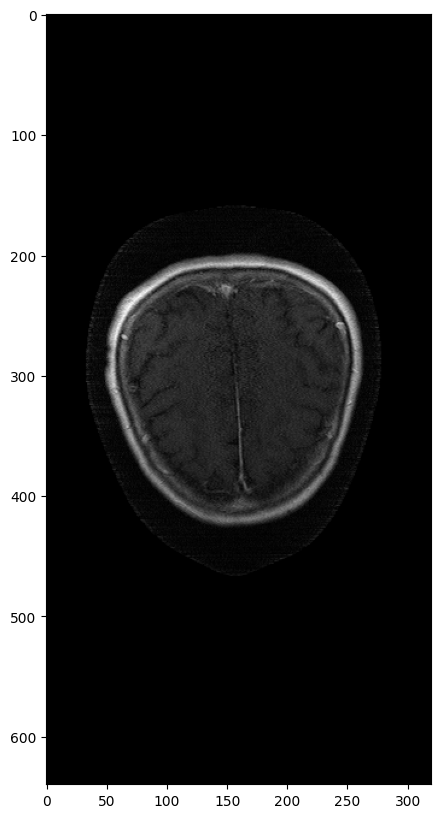

In [100]:
# no reg
im_sense = bart.bart(1, 'pics', ksp_masked_b, smap)
disp(im_sense)

Size: 204800 Samples: 49280 Acc: 4.16
TV regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
Stepsize ignored.
ADMM
Total Time: 2.666556


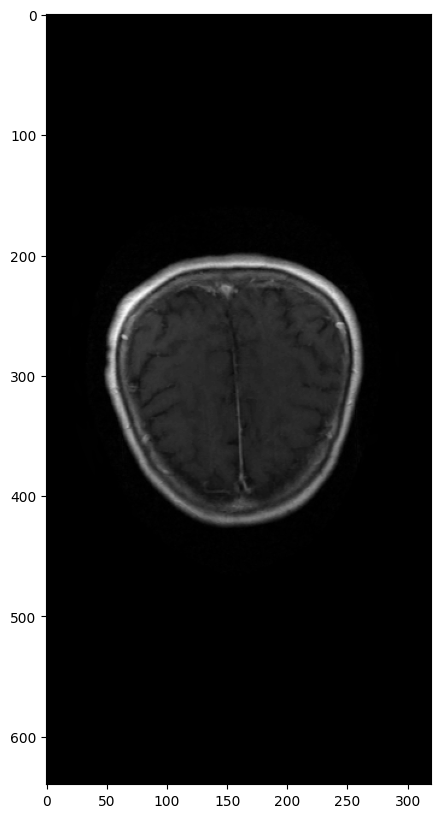

In [102]:
lam = 0.01
num = !bart bitmask 1 2
im_tv = bart.bart(1, 'pics -R T:{}:0:{} -S -s {}'.format(num[0], lam, 1), ksp_masked_b, smap)
disp(im_tv)

In [109]:
all_scores = np.array([0.0,0.0,0.0])
crop_sense = crop_center(im_sense[None])
sense_norm = normalize_abs(crop_sense)

crop_wav = crop_center(im_wav[None])
wav_norm = normalize_abs(crop_wav)

crop_tv = crop_center(im_tv[None])
tv_norm = normalize_abs(crop_tv)

out_rss_n = normalize_abs(out_rss)

score_s, _ = ssim(out_rss_n,sense_norm,data_range=1, full=True)
score_s = round(score_s,3)
score_w, _ = ssim(out_rss_n,wav_norm,data_range=1, full=True)
score_w = round(score_w,3)
score_t, _ = ssim(out_rss_n,tv_norm,data_range=1, full=True)
score_t = round(score_t,3)

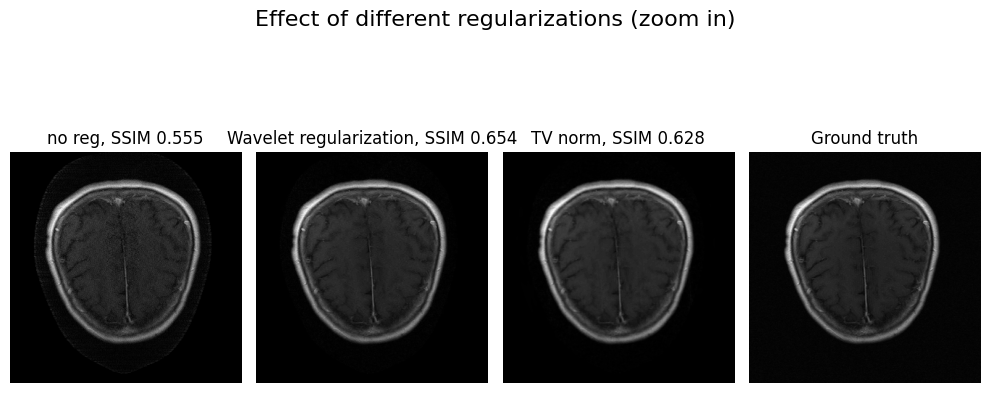

In [125]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))  # 1 row, 2 columns

# Plot the first image
axes[0].imshow(sense_norm, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('no reg, SSIM {}'.format(score_s))
axes[0].axis('off')  # Hide the axis

# Plot the second image
axes[1].imshow(wav_norm, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Wavelet regularization, SSIM {}'.format(score_w))
axes[1].axis('off')  # Hide the axis


axes[2].imshow(tv_norm, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('TV norm, SSIM {}'.format(score_t))
axes[2].axis('off')  # Hide the axis

# Plot the second image
axes[3].imshow(out_rss_n, cmap='gray', vmin=0, vmax=1)
axes[3].set_title('Ground truth')
axes[3].axis('off')  # Hide the axis



fig.suptitle("Effect of different regularizations (zoom in)", fontsize=16)
# Display the plot
plt.savefig("pics_espirit_new.png", dpi=300, bbox_inches='tight')
plt.tight_layout()  # Adjust spacing
plt.show()

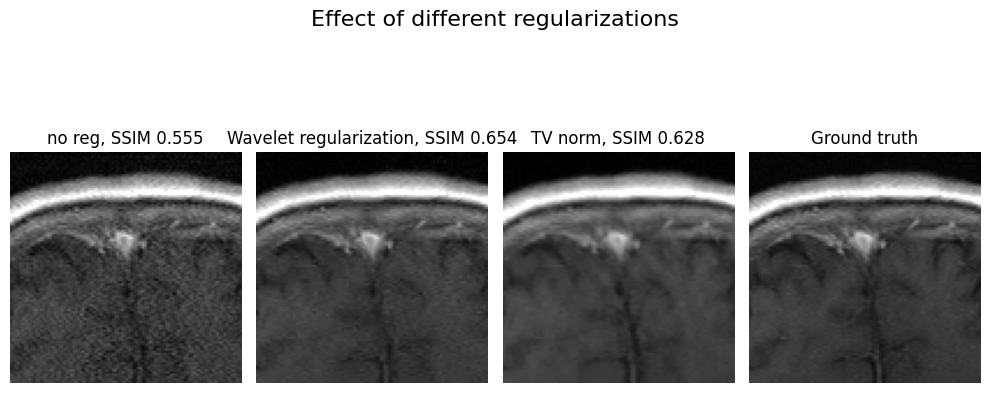

In [124]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))  # 1 row, 2 columns

# Plot the first image
axes[0].imshow(sense_norm[30:130,100:200], cmap='gray', vmin=0, vmax=0.7)
axes[0].set_title('no reg, SSIM {}'.format(score_s))
axes[0].axis('off')  # Hide the axis

# Plot the second image
axes[1].imshow(wav_norm[30:130,100:200], cmap='gray', vmin=0, vmax=0.7)
axes[1].set_title('Wavelet regularization, SSIM {}'.format(score_w))
axes[1].axis('off')  # Hide the axis


axes[2].imshow(tv_norm[30:130,100:200], cmap='gray', vmin=0, vmax=0.7)
axes[2].set_title('TV norm, SSIM {}'.format(score_t))
axes[2].axis('off')  # Hide the axis

# Plot the second image
axes[3].imshow(out_rss_n[30:130,100:200], cmap='gray', vmin=0, vmax=0.7)
axes[3].set_title('Ground truth')
axes[3].axis('off')  # Hide the axis



fig.suptitle("Effect of different regularizations", fontsize=16)
# Display the plot
plt.savefig("pics_espirit_new.png", dpi=300, bbox_inches='tight')
plt.tight_layout()  # Adjust spacing
plt.show()

In [170]:
recon.shape, out.shape

(torch.Size([16, 640, 320]), (16, 320, 320))

## Reconstruct all the slices in the volume, calculate metrics with different acceleration factors

In [181]:
kspace = volume_kspace
int_acc_all = [2,5,8]
all_mets = np.zeros((len(int_acc_all),3),dtype=np.float64)
count =0

for int_acc in int_acc_all:
    downsampling_func = EquiSpacedMaskFunc(center_fractions=[0.04], accelerations=[int_acc])
    downsampled , mask, _ = T.apply_mask(T.to_tensor(kspace), downsampling_func)
    downsampled = downsampled[...,0] + 1j * downsampled[...,1]
    downsampled = downsampled.numpy()
    calib = kspace[...,kspace.shape[-1]//2-kspace.shape[-1]//50:kspace.shape[-1]//2+kspace.shape[-1]//50]
    # reconstruct k-space
    recon = recon_epics_vol(downsampled, "")
    recon_c = eval.normalize(crop_center(recon[None]))
    
    out_n = eval.normalize(torch.tensor(out))
    mets  = eval.evaluate(out_n,recon_c[0])
    all_mets[count] = mets
    print(int_acc)
    print(mets)

    count = count + 1

(16, 16, 640, 320)
torch.Size([16, 640, 320])
Size: 204800 Samples: 76159 Acc: 2.69
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 16.634022
Size: 204800 Samples: 76159 Acc: 2.69
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 17.206830
Size: 204800 Samples: 76159 Acc: 2.69
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 17.306049
Size: 204800 Samples: 76159 Acc: 2.69
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 17.256551
Size: 204800 Samples: 76159 Acc: 2.69
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 16.832713
Size: 204800 Samples: 76159 Acc: 2.69
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 20.649803
Size: 204800 Samples: 76159 Acc: 2.69
l1-wavelet

# Show results

In [167]:
count = 0
for int_acc in int_acc_all:
    print("Acceleration factor (R):{}".format(int_acc))
    print("MSE: {}".format(all_mets[count][0]))
    print("PSNR: {}".format(all_mets[count][1]))
    print("SSIM: {}".format(all_mets[count][2]))
    print("")
    count = count + 1

Acceleration factor (R):2
MSE: 0.015309520065784454
PSNR: 18.1503849029541
SSIM: 0.16447429358959198

Acceleration factor (R):5
MSE: 0.01530984416604042
PSNR: 18.150293350219727
SSIM: 0.16446232795715332

Acceleration factor (R):8
MSE: 0.015311031602323055
PSNR: 18.14995574951172
SSIM: 0.16454757750034332



Size: 204800 Samples: 49280 Acc: 4.16
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2   1 640 320  16 ]
[  4   0   8 5120 1638400 ]
[  4   0   8 5120 1638400 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[6553600 ]
[  4 ]
[  4 ]
[  0 ]
Calibration region...  (size: 1x32x12, pos: 0x304x154)
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2   1  32  12  16 ]
[  4   0   8 256 3072 ]
[  4   0   8 256 3072 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[12288 ]
[  4 ]
[  4 ]
[  0 ]
Scaling: 0.000159  (max = 0.000436/p90 = 0.000159/median = 0.000007)
Inverse scaling of the data: 0.000159
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2   1 640 320  16 ]
[  4   0   8 5120 1638400 ]
[  4   0   8 5120 1638400 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[6553600 ]
[  4 ]
[  4 ]
[  0 ]
l2 regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
conjugate gradients

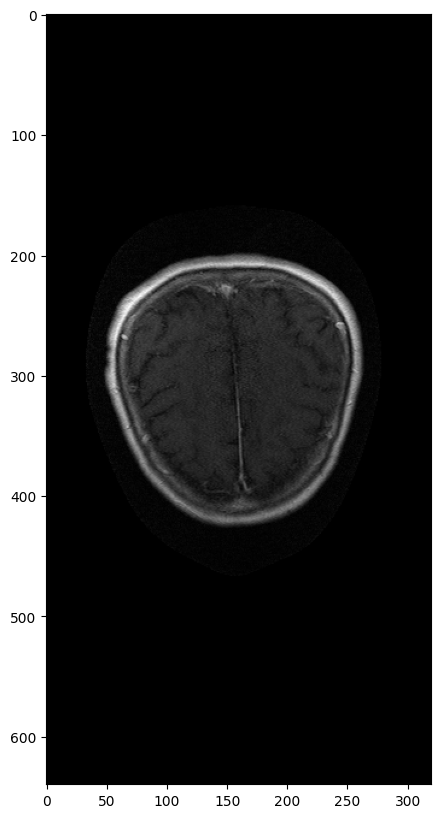

In [904]:
l2_reg = 0.01
im_l2 = bart.bart(1, 'pics -R Q:{} -S -d5'.format(l2_reg), ksp_masked_b, smap)
disp(im_l2)

In [434]:
!bart itsense -h

Usage: itsense alpha <sensitivities> <kspace> <pattern> <output> 

A simplified implementation of iterative sense reconstruction
with l2-regularization.

-h  help


In [449]:
!bart pics -h

Usage: pics [-l ...] [-r f] [-R ...] [-c] [-s f] [-i d] [-t <file>] [-n] [-N] [-g] [--gpu-gridding] [-p <file>] [--precond] [-b d] [-e] [-W <file>] [-d d] [-u f] [-C d] [-f f] [-I,--ist] [--fista] [--eulermaruyama] [-m,--admm] [-a,--pridu] [-w f] [-S] [--shared-img-dims d] [-K] [-B <file>] [-P f] [-M] [-U,--lowmem] [--no-toeplitz] [--psf_export <file>] [--psf_import <file>] [--wavelet <string>] [--mpi d] [--fista_pqr f:f:f] [--fista_last] [--motion-field <file>] <kspace> <sensitivities> <output> 

Parallel-imaging compressed-sensing reconstruction.


-l1/-l2                    toggle l1-wavelet or l2 regularization.
-r lambda                  regularization parameter
-R <T>:A:B:C               generalized regularization options (-Rh for help)
-c                         real-value constraint
-s step                    iteration stepsize
-i iter                    max. number of iterations
-t file                    k-space trajectory
-n                         disable random wavelet cyc

In [413]:
!bart pics -h

Usage: pics [-l ...] [-r f] [-R ...] [-c] [-s f] [-i d] [-t <file>] [-n] [-N] [-g] [--gpu-gridding] [-p <file>] [--precond] [-b d] [-e] [-W <file>] [-d d] [-u f] [-C d] [-f f] [-I,--ist] [--fista] [--eulermaruyama] [-m,--admm] [-a,--pridu] [-w f] [-S] [--shared-img-dims d] [-K] [-B <file>] [-P f] [-M] [-U,--lowmem] [--no-toeplitz] [--psf_export <file>] [--psf_import <file>] [--wavelet <string>] [--mpi d] [--fista_pqr f:f:f] [--fista_last] [--motion-field <file>] <kspace> <sensitivities> <output> 

Parallel-imaging compressed-sensing reconstruction.


-l1/-l2                    toggle l1-wavelet or l2 regularization.
-r lambda                  regularization parameter
-R <T>:A:B:C               generalized regularization options (-Rh for help)
-c                         real-value constraint
-s step                    iteration stepsize
-i iter                    max. number of iterations
-t file                    k-space trajectory
-n                         disable random wavelet cyc

In [412]:
!bart pics -Rh -h

Generalized regularization options (experimental)

-R <T>:A:B:C	<T> is regularization type (single letter),
		A is transform flags, B is joint threshold flags,
		and C is regularization value. Specify any number
		of regularization terms.

-R Q:C    	l2-norm in image domain
-R I:B:C  	l1-norm in image domain
-R W:A:B:C	l1-wavelet
-R N:A:B:C	Normalized Iterative Hard Thresholding (NIHT), image domain
		C is an integer percentage, i.e. from 0-100
-R H:A:B:C	NIHT, wavelet domain
-R F:A:B:C	l1-Fourier
-R T:A:B:C	total variation
-R T:7:0:.01	3D isotropic total variation with 0.01 regularization.
-R G:A:B:C	total generalized variation
-R C:A:B:C	infimal convolution TV
-R L:7:7:.02	Locally low rank with spatial decimation and 0.02 regularization.
-R M:7:7:.03	Multi-scale low rank with spatial decimation and 0.03 regularization.
-R TF:{graph_path}:lambda	TensorFlow loss


In [1124]:
!bart pics -h

Usage: pics [-l ...] [-r f] [-R ...] [-c] [-s f] [-i d] [-t <file>] [-n] [-N] [-g] [--gpu-gridding] [-p <file>] [--precond] [-b d] [-e] [-W <file>] [-d d] [-u f] [-C d] [-f f] [-I,--ist] [--fista] [--eulermaruyama] [-m,--admm] [-a,--pridu] [-w f] [-S] [--shared-img-dims d] [-K] [-B <file>] [-P f] [-M] [-U,--lowmem] [--no-toeplitz] [--psf_export <file>] [--psf_import <file>] [--wavelet <string>] [--mpi d] [--fista_pqr f:f:f] [--fista_last] [--motion-field <file>] <kspace> <sensitivities> <output> 

Parallel-imaging compressed-sensing reconstruction.


-l1/-l2                    toggle l1-wavelet or l2 regularization.
-r lambda                  regularization parameter
-R <T>:A:B:C               generalized regularization options (-Rh for help)
-c                         real-value constraint
-s step                    iteration stepsize
-i iter                    max. number of iterations
-t file                    k-space trajectory
-n                         disable random wavelet cyc

Size: 204800 Samples: 49280 Acc: 4.16
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2   1 640 320  16 ]
[  4   0   8 5120 1638400 ]
[  4   0   8 5120 1638400 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[6553600 ]
[  4 ]
[  4 ]
[  0 ]
Calibration region...  (size: 1x32x12, pos: 0x304x154)
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2   1  32  12  16 ]
[  4   0   8 256 3072 ]
[  4   0   8 256 3072 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[12288 ]
[  4 ]
[  4 ]
[  0 ]
Scaling: 0.000159  (max = 0.000436/p90 = 0.000159/median = 0.000007)
Inverse scaling of the data: 0.000159
md_mul optimized by blas_mul_sscal: 
 Old dims/strides:
[  2   1 640 320  16 ]
[  4   0   8 5120 1638400 ]
[  4   0   8 5120 1638400 ]
[  0   0   0   0   0 ]
optimized dims/strides (N=1 by strided kernel):
[6553600 ]
[  4 ]
[  4 ]
[  0 ]
l1-wavelet regularization: 0.100000
Regularization terms: 1, Supporting variables: 0
FISTA
#It 0

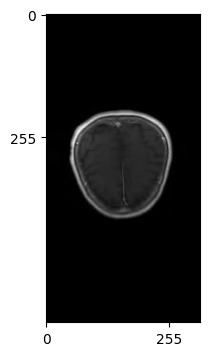

In [417]:
l1wav_reg = 0.1
num = !bart bitmask 1 2
#im_rss = bart.bart(1, 'rss {}'.format(num[0]), im_coil)

im_wav = bart.bart(1, 'pics -R W:{}:0:{} -S -d5'.format(num[0], l1wav_reg), ksp_masked_b, smap)
disp(im_wav)